# Chain

<center><img src="../../../assets/chain.png" width="900" height="300" alt="chain"></img></center>

Now, let's build a chain, which is a process that is composed by sequential sub processes. Here we will use 4 concepts:

1. Using chat messages in the graph
2. Using chat models
3. Binding tools to our LLM
4. Executing tools calls in our graph

## Dependencies

In [43]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages 
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

## Messages

Chat models uses `messages` as the content for input and outputs, this will model a conversation, which later we will calla `thread`.

In the conversation a `message` can take different roles, including human content (`HumanMessage`), chat model content (`AIMessage`), the chat instruct behaviour (`SystemMessage`) and tool answer (`ToolMessage`).

Let's create a list of messages. Each message can be supplied with a few attributes:

- `content` - Content of the message
- `name` - optional, who is creating the message
- `response_metadata` - optional, a dictionary of metadata specific to each model provider (openai,  anthropic, llama, etc)

In [44]:
messages = [AIMessage(content=f"Hi, I'm a bot!", name="Bot")]
messages.extend([HumanMessage(content=f"Hi, I'm a human!", name="Guilherme")])
messages.extend([AIMessage(content=f"Hi human, how can I assist you today?", name="Bot")])
messages.extend([HumanMessage(content=f"Can you tell me the weather in New York?", name="Guilherme")])


for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi, I'm a bot!
================================ Human Message =================================
Name: Guilherme

Hi, I'm a human!
================================== Ai Message ==================================
Name: Bot

Hi human, how can I assist you today?
================================ Human Message =================================
Name: Guilherme

Can you tell me the weather in New York?


## Chat Models

A chat model can use a sequence of messages as input and support messages roles, as discussed above.

There are many to choose from such as OpenAI models, Anthropic, Google, etc. we are going to use Llama 3.1 8B from Ollama which is locally installed.

We will load the chat model and invoke it with alistof messages.

The result is an `AIMessage`.

In [45]:
llm = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    max_tokens=512,
    temperature=0.8,
)

In [46]:
response = llm.invoke(messages)
response.content

"I'd love to help. However, I'm a large language model, I don't have real-time access to current weather conditions. But I can suggest some ways for you to find out the current weather in New York:\n\n1. You can check online weather websites such as accuweather.com or wunderground.com.\n2. Use a virtual assistant like Siri, Google Assistant, or Alexa to ask about the weather in New York.\n3. Check the website of the National Weather Service (weather.gov) for up-to-date forecasts and current conditions.\n\nIf you want, I can also suggest some ways to find out the typical weather patterns for different seasons in New York?"

In [47]:

type(response)

langchain_core.messages.ai.AIMessage

In [48]:
response.response_metadata

{'model': 'llama3.1',
 'created_at': '2024-12-28T00:22:36.1922195Z',
 'done': True,
 'done_reason': 'stop',
 'total_duration': 3566427200,
 'load_duration': 24378700,
 'prompt_eval_count': 59,
 'prompt_eval_duration': 174000000,
 'eval_count': 136,
 'eval_duration': 2804000000,
 'message': Message(role='assistant', content='', images=None, tool_calls=None)}

## Tool

A tool is needed whenever you want a mode to control  parts of your code or call  out externalAPIs.

Many LLM providers support tool calling.

The tool calling interface in LangChain is simple, you can pass any Python function into `ChaModel.bind_tools()`.

<center><img src="../../../assets/tool.png" width="900" alt="tool"></img></center>


In [49]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and  b

    Args:
        a (int): First number
        b (int): Second number
    """
    return a * b

In [50]:
llm_with_tools = llm.bind_tools([multiply])

In [51]:
tool_call = llm_with_tools.invoke([HumanMessage(content="Can you multiply 2 by 3?", name="Guilherme")])
tool_call

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-28T00:22:45.5490996Z', 'done': True, 'done_reason': 'stop', 'total_duration': 839630500, 'load_duration': 15370100, 'prompt_eval_count': 176, 'prompt_eval_duration': 264000000, 'eval_count': 22, 'eval_duration': 558000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-0bdc3b09-ea0d-4a88-a0c9-0568247bf6b4-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '3f2aca8c-abc8-4104-a19a-2cfab218a04d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 22, 'total_tokens': 198})

In [52]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '3f2aca8c-abc8-4104-a19a-2cfab218a04d',
  'type': 'tool_call'}]

## Putting all together - Graph

Let's use `messages` in our graph state, first let's define the `MessageState` by inheriting `TypedDict` with a single key: `messages`, which is simply a list od `AnyMessage`

In [53]:
class MessagesState(TypedDict):

    messages: list[AnyMessage]

## Reducers

But we have a problem, as our graph runs, we want ttto append messages to our `messages` state key, however, naturally the graph override the state at each step.

So we can use reducers, they allow us to specify how state updates are performed at key level.

If no reducer is provided, the graph will override the state, since we want to append the messages we can use the pre-built `add_messages` reducer.

In [54]:
class MessagesState(TypedDict):
    
    messages: Annotated[list[AnyMessage], add_messages]

## Graph Construction

In [55]:
def tool_calling_llm(state: MessagesState):
    return {
        "messages": llm_with_tools.invoke(state["messages"])
    }

In [56]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_edge("tool_calling_llm", END)
graph = graph_builder.compile()

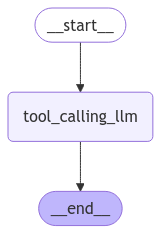

In [57]:
display(Image(graph.get_graph().draw_mermaid_png()))

Let's invoke the LLM such that it won't invoke any tool.

In [58]:
messages = graph.invoke({"messages": HumanMessage(content="Hello", name="Guilherme")})
messages

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, name='Guilherme', id='7e37dcf8-459d-4178-bf3d-c6490a16204f'),
  AIMessage(content='No JSON response is needed as the function call does not match any of the provided functions. The prompt "Hello" does not relate to any mathematical operation and therefore cannot be answered using the given functions.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-28T00:22:59.7119745Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1047868300, 'load_duration': 15262500, 'prompt_eval_count': 168, 'prompt_eval_duration': 59000000, 'eval_count': 41, 'eval_duration': 972000000, 'message': Message(role='assistant', content='No JSON response is needed as the function call does not match any of the provided functions. The prompt "Hello" does not relate to any mathematical operation and therefore cannot be answered using the given functions.', images=None, tool_calls=None)}, i

Now, let's invoke the tool call!

In [59]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 4 by 5", name="Guilherme")})
messages

{'messages': [HumanMessage(content='Multiply 4 by 5', additional_kwargs={}, response_metadata={}, name='Guilherme', id='d0322937-41bb-4fb5-8528-8716c4405380'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-28T00:24:39.0839506Z', 'done': True, 'done_reason': 'stop', 'total_duration': 660922100, 'load_duration': 21416900, 'prompt_eval_count': 173, 'prompt_eval_duration': 131000000, 'eval_count': 22, 'eval_duration': 507000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-fa436e11-6b9d-4fc6-a9e9-0e13114484c9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 5}, 'id': '6e7607e6-70f6-47ea-9cc7-761a2e859006', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 22, 'total_tokens': 195})]}